# Chapter 02 - Small Worlds and Large Worlds

In [1]:
import warnings

import pandas as pd
import proplot as plot
import pyro
import pyro.distributions as dist
import pyro.infer
import pyro.optim
import torch
import torch.distributions.constraints as constraints
import torch.tensor as tensor
from pyro.contrib.autoguide import AutoLaplaceApproximation

warnings.filterwarnings("ignore")
%pylab inline

pyro.set_rng_seed(42)

plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["font.weight"] = "bold"

Populating the interactive namespace from numpy and matplotlib


# Code 2.1

In [2]:
ways = tensor([0, 3, 8, 9, 0], dtype=float)
ways / ways.sum()

tensor([0.0000, 0.1500, 0.4000, 0.4500, 0.0000], dtype=torch.float64)

# Code 2.2

In [3]:
dist.Binomial(total_count=9, probs=0.5).log_prob(tensor(6, dtype=float)).exp()

tensor(0.1641, dtype=torch.float64)

# Code 2.3

In [4]:
p_grid = torch.linspace(start=0, end=1, steps=20)

prior = tensor([1.0] * 20)

likelihood = dist.Binomial(total_count=9, probs=p_grid).log_prob(tensor(6.0)).exp()

unstd_posterior = likelihood * prior

posterior = unstd_posterior / unstd_posterior.sum()

# Figure 2.7

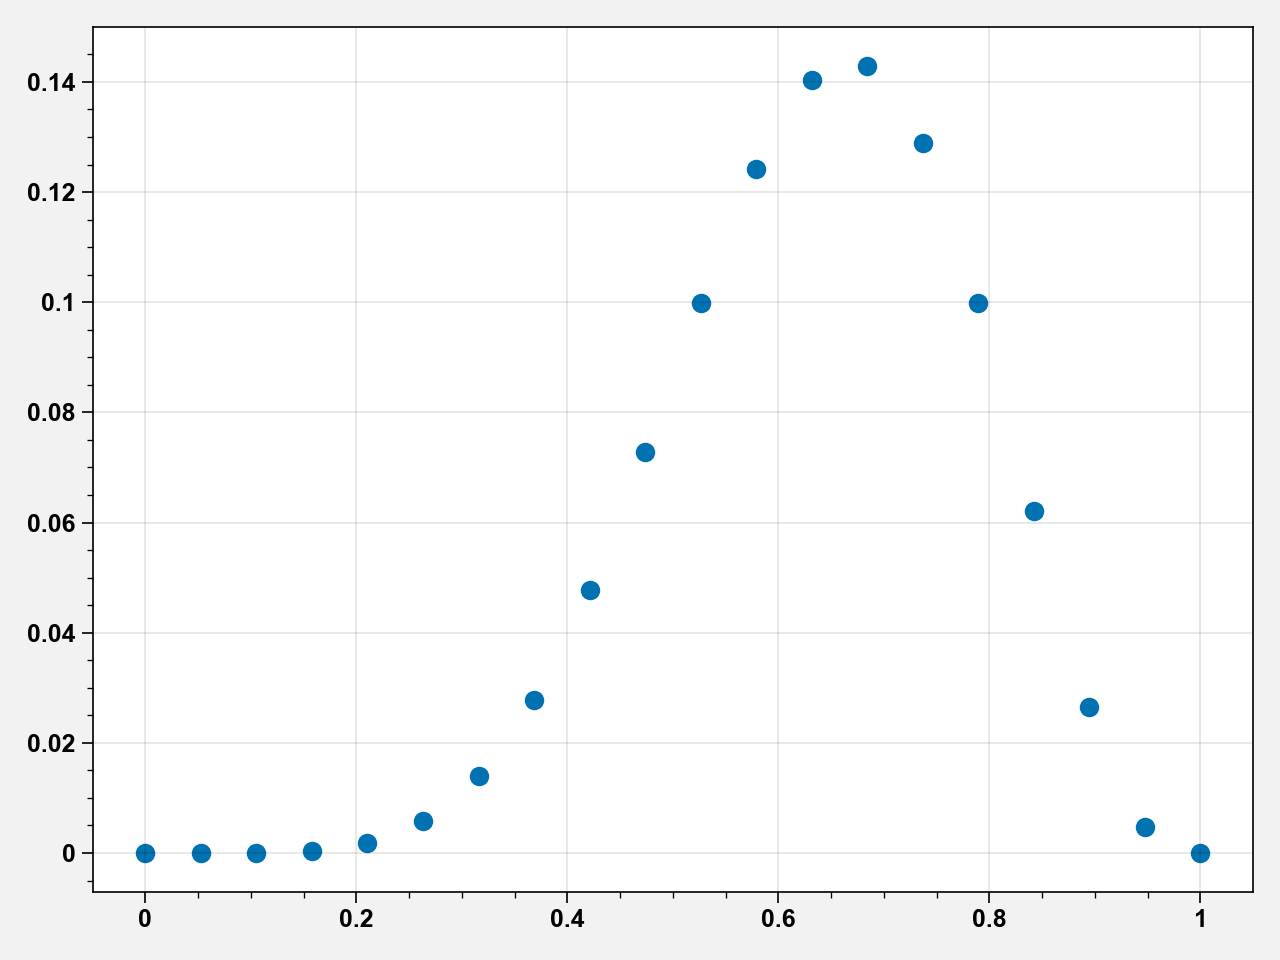

In [5]:
fig, ax = plt.subplots()
ax.scatter(p_grid, posterior)
fig.tight_layout()

# Code 2.5

In [6]:
prior[prior < 0.5] = 0
prior[prior >= 0.5] = 1

prior = torch.exp(-5 * torch.abs(prior - 0.5))

likelihood = dist.Binomial(total_count=9, probs=p_grid).log_prob(tensor(6.0)).exp()

unstd_posterior = likelihood * prior

posterior = unstd_posterior / unstd_posterior.sum()

In [7]:
prior

tensor([0.0821, 0.0821, 0.0821, 0.0821, 0.0821, 0.0821, 0.0821, 0.0821, 0.0821,
        0.0821, 0.0821, 0.0821, 0.0821, 0.0821, 0.0821, 0.0821, 0.0821, 0.0821,
        0.0821, 0.0821])

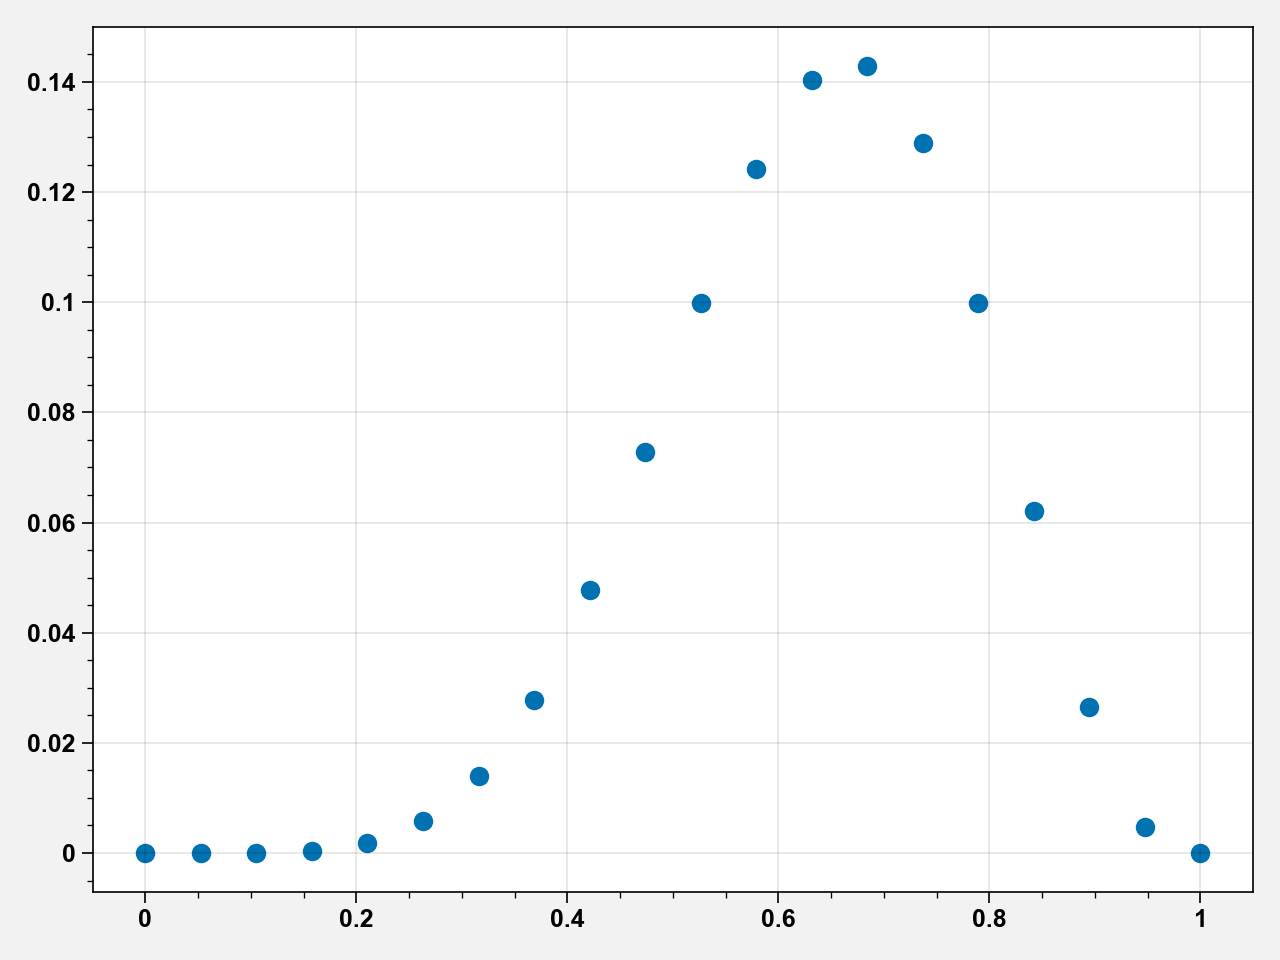

In [8]:
fig, ax = plt.subplots()
ax.scatter(p_grid, posterior)
fig.tight_layout()

# Code 2.6

p =  0.6666584014892578


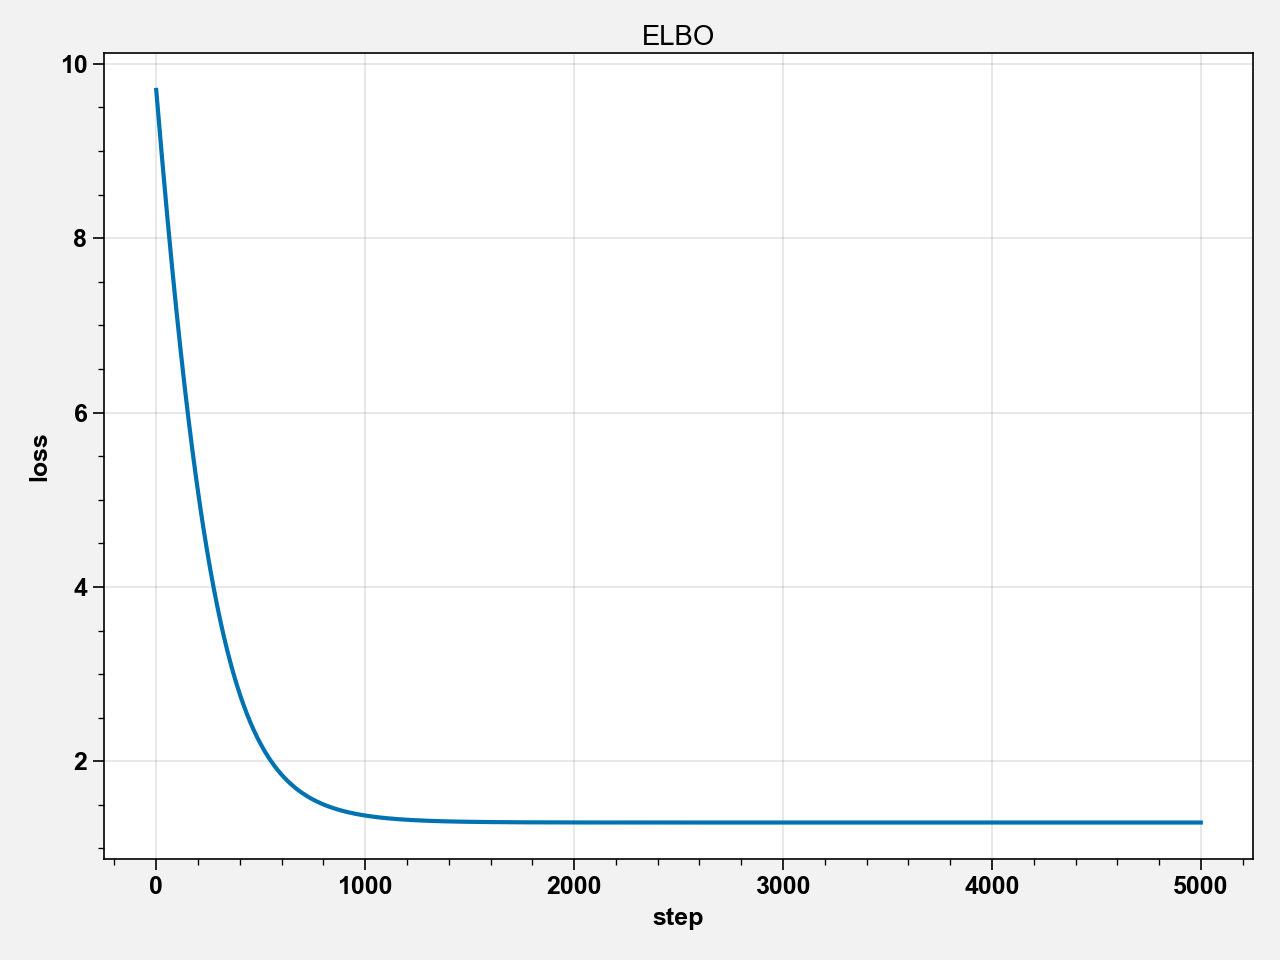

In [9]:
def summary(samples, prob=0.95):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0).data.numpy(),
            "std": torch.std(v, 0).data.numpy(),
            "{:.1f}%".format(100 * (1 - prob)): v.kthvalue(
                int(len(v) * (1 - prob)), dim=0
            )[0].data.numpy(),
            "{:.1f}%".format(100 * prob): v.kthvalue(int(len(v) * prob), dim=0)[
                0
            ].data.numpy(),
        }
    return pd.DataFrame(site_stats)


def model(n):
    p = pyro.sample("p", dist.Uniform(0, 1.0))
    return pyro.sample("w", dist.Binomial(n, p))


def guide(n):
    p_param = pyro.param(
        "p_param", torch.tensor(0.1), constraint=constraints.unit_interval
    )
    return pyro.sample("p", dist.Delta(p_param))


conditioned = pyro.condition(model, data={"w": tensor(6.0)})

pyro.clear_param_store()
svi = pyro.infer.SVI(
    model=conditioned,
    guide=guide,
    optim=pyro.optim.SGD({"lr": 0.001, "momentum": 0.1}),
    loss=pyro.infer.Trace_ELBO(),
)

n = 9
losses, p_param = [], []
num_steps = 5000
for t in range(num_steps):
    losses.append(svi.step(n))
plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")
plt.tight_layout()
print("p = ", pyro.param("p_param").item())

In [10]:
# Need this for estinamting standard deviation of the posterior
# See: https://forum.pyro.ai/t/standard-deviation-of-the-posterior/1916
n = 9
w = 6.0
pyro.clear_param_store()

conditioned = pyro.condition(model, data={"w": tensor(w)})

guide = pyro.infer.autoguide.AutoLaplaceApproximation(conditioned)
laplace_guide = guide.laplace_approximation(n)
pred = pyro.infer.Predictive(laplace_guide, num_samples=10000)
p_summary = summary(pred.get_samples(), 0.945).loc[:, ["p"]]
p_posterior_mean = tensor(p_summary.loc["mean", "p"])
p_posterior_std = tensor(p_summary.loc["std", "p"])
p_summary

,p
mean,0.7214124
std,0.12918343
5.5%,0.48164606
94.5%,0.8951862


# Code 2.7

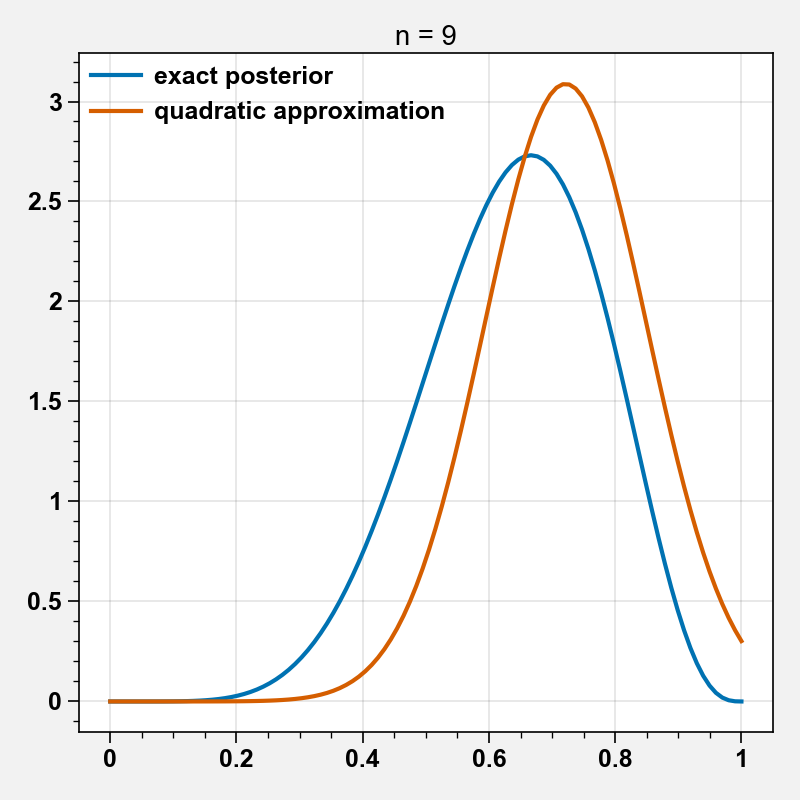

In [11]:
w = 6
n = 9
p_grid = torch.linspace(0.0, 1.0, 100)
# exact posterior
exact_density = dist.Beta(w + 1, n - w + 1).log_prob(p_grid).exp()
quad_density = dist.Normal(p_posterior_mean, p_posterior_std).log_prob(p_grid).exp()


fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(p_grid, exact_density, label="exact posterior")
ax.plot(p_grid, quad_density, label="quadratic approximation")
ax.legend(loc=2, frameon=False)
ax.set_title("n = 9")
fig.tight_layout()

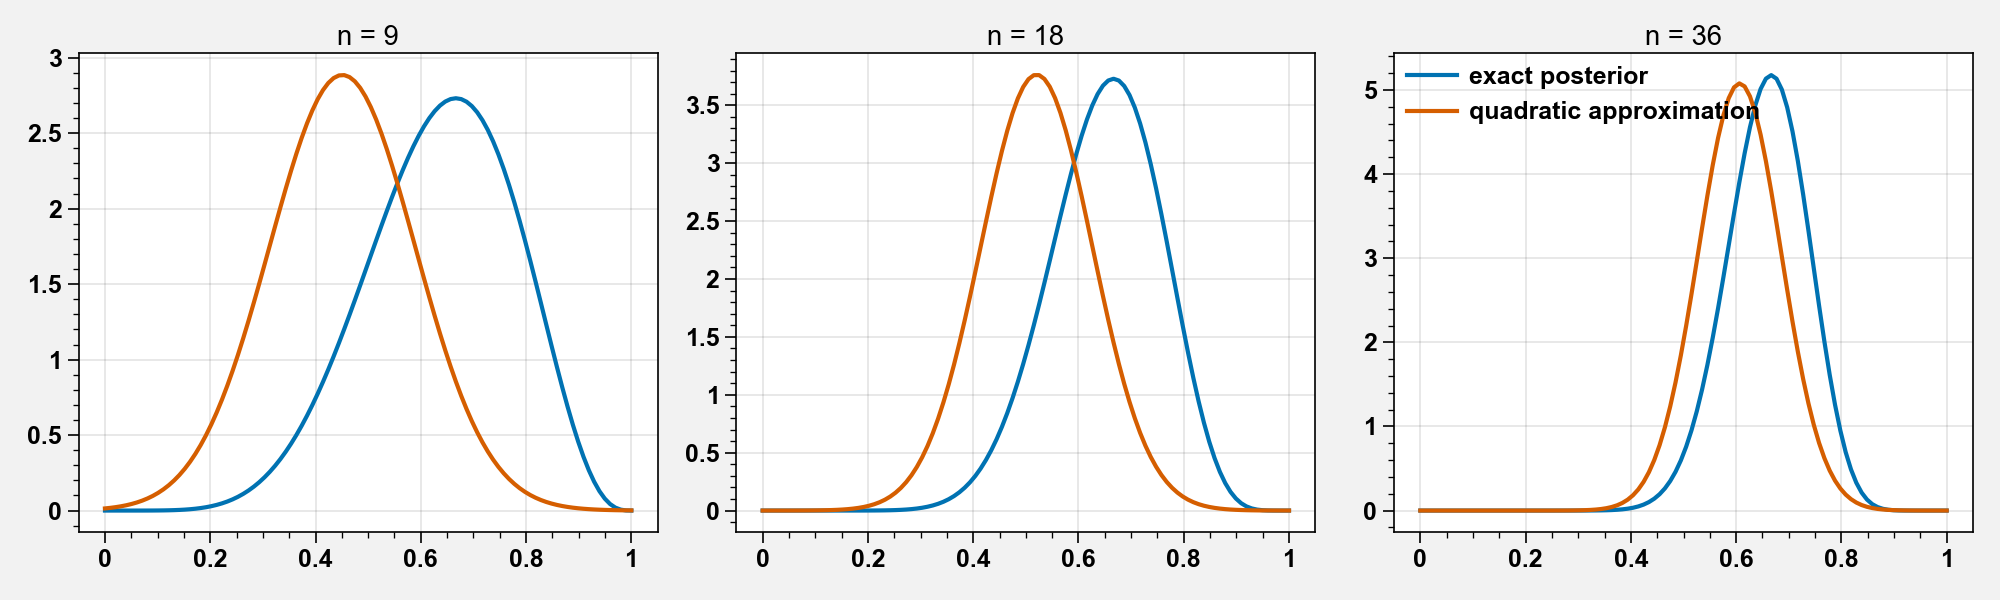

In [12]:
# play with w, n

fig = plt.figure(figsize=(10, 3))
for i, (w, n) in enumerate([(6.0, 9), (12.0, 18), (24.0, 36)]):
    ax = plt.subplot(1, 3, i + 1)
    ax.set_title("n = {}".format(n))
    exact_density = dist.Beta(w + 1, n - w + 1).log_prob(p_grid).exp()

    pyro.clear_param_store()

    conditioned = pyro.condition(model, data={"w": tensor(w)})

    guide = pyro.infer.autoguide.AutoLaplaceApproximation(conditioned)
    laplace_guide = guide.laplace_approximation(n)
    pred = pyro.infer.Predictive(laplace_guide, num_samples=10000)
    p_summary = summary(pred.get_samples(), 0.945).loc[:, ["p"]]
    p_posterior_mean = tensor(p_summary.loc["mean", "p"])
    p_posterior_std = tensor(p_summary.loc["std", "p"])

    quad_density = dist.Normal(p_posterior_mean, p_posterior_std).log_prob(p_grid).exp()

    ax.plot(p_grid, exact_density, label="exact posterior")
    ax.plot(p_grid, quad_density, label="quadratic approximation")
ax.legend(loc=2, frameon=False)
fig.tight_layout()

# TODO: